# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


In [65]:
# --- Environment & Imports ---
import os, glob, math, time, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, pandas as pd
from importlib import reload

In [66]:
# --- Import model code + instantiate before loading checkpoint ---
import os, torch
from importlib import reload

# Ensure we are in project root
os.chdir(r"C:\Users\Windows User\NMR-Project")

# Make sure functions is a package
init_path = os.path.join("functions", "__init__.py")
if not os.path.exists(init_path):
    open(init_path, "a").close()

# Import neural_net module
import functions.neural_net as nnets
reload(nnets)  # safe during edits

from functions.neural_net import DenoiseNetPhysics, build_model_from_latest, count_params

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Device] Using {device}")

# Checkpoint dir + latest name
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
LATEST_NAME = "DenoiseNetPhysics_latest.pth"

# Build first, then load weights
model_physics, loaded_path = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)

# Param report
total_params, trainable_params = count_params(model_physics)
print(f"Model: {model_physics.__class__.__name__} | params={total_params:,} trainable={trainable_params:,} | ckpt={loaded_path}")

# Optional concise architecture head
print("Architecture head:")
for i, line in enumerate(repr(model_physics).splitlines()):
    if i > 20: 
        print("  ..."); break
    print(" ", line)

[Device] Using cpu
[Info] Loaded checkpoint: C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Model: DenoiseNetPhysics | params=544,322 trainable=544,322 | ckpt=C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Architecture head:
  DenoiseNetPhysics(
    (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (blocks): Sequential(
      (0): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      )
      (1): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      )
      (2): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,),

#### This is an optimizer. I should ask about this

In [67]:
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

## 🎛 Hyperparameter Guide (Training Config)

---

### **1️⃣ EPOCHS = 6**
- **What it means:** One full pass over your training curriculum.  
- **Intuition:** The model “reads” the entire (synthetic) dataset once per epoch; 6 epochs = 6 passes.  
- **Tune:**  
  - ✅ Increase if underfitting (loss still improving, predictions weak).  
  - ⚠️ Decrease if overfitting (train loss drops, validation/real performance worsens).  

---

### **2️⃣ STEPS_PER_EPOCH = 40**
- **What it means:** Number of mini-batches per epoch (you synthesize data on the fly).  
- **Intuition:** After 40 updates, call it an epoch even without a fixed dataset size.  
- **Tune:**  
  - ✅ Increase for more gradient updates per epoch (more compute).  
  - ⚠️ Decrease if training is too slow or your data volume is small.  

---

### **3️⃣ BATCH_SIZE = 8**
- **What it means:** Samples processed together before one optimizer step.  
- **Intuition:**  
  - Smaller batches → noisier updates, better generalization, less memory.  
  - Larger batches → smoother updates, faster, but more memory.  
- **Tune:**  
  - ✅ Increase if GPU RAM allows (more stable/faster).  
  - ⚠️ Decrease if memory-limited or want extra regularization via noisier gradients.  

---

### **4️⃣ CROP_LEN = 2048**
- **What it means:** Length of each input segment (points) from the FID.  
- **Intuition:** Train on fixed-size windows to learn local patterns without full-length overhead.  
- **Tune:**  
  - ✅ Increase for longer-range patterns or receptive field coverage.  
  - ⚠️ Decrease if memory is tight or to allow more slice variety per trace.  

---

### **5️⃣ NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]**
- **What it means:** Per-epoch noise level (post tail-RMS scaling) for synthetic training.  
- **Intuition:** Start harder (noisy) and gradually cleaner to refine details — **curriculum learning**.  
- **Tune:**  
  - ✅ Increase if real FIDs are very noisy (robustness).  
  - ⚠️ Decrease if convergence is unstable or data is already clean.  

---

### **6️⃣ REAL_FINETUNE_EPOCHS = 1**
- **What it means:** Passes over your real `.asc` files for self-denoising fine-tuning.  
- **Intuition:** Adapt filters from synthetic data to real acquisition artifacts.  
- **Tune:**  
  - ✅ Increase with more/better real data for stronger adaptation.  
  - ⚠️ Keep low if dataset is small to avoid overfitting.  

---

### **7️⃣ REAL_BATCH_SIZE = 8**
- **What it means:** Batch size used during real-data fine-tuning.  
- **Intuition:** Same trade-offs as `BATCH_SIZE` but applied to real data.  
- **Tune:**  
  - ✅ Increase for stability/throughput if memory allows.  
  - ⚠️ Decrease to fit larger crops or longer traces.  

---

## **📌 At a Glance**
- **Epochs:** how many times the model sees the dataset.  
- **Steps per epoch:** how many mini-updates per epoch.  
- **Batch size:** how many spectra per mini-update.  
- **Crop length:** how long each training slice is.  
- **Noise schedule:** how noisy each epoch’s synthetic data is.  
- **Real fine-tuning:** extra passes on actual data to specialize.  


In [68]:
import importlib, functions.neural_net as nnets
importlib.reload(nnets)
from functions.neural_net import combined_loss, synth_batch_phys
from torch.amp import autocast, GradScaler

# ---- 6) Curriculum training with combined_loss ----
# an epoch is how many times the neural net will go through all of the dataset. 
#increase the number of epochs if the model is underfitted and decrease if overfitted

EPOCHS = 20                # increased epochs
STEPS_PER_EPOCH = 80
BATCH_SIZE = 8
CROP_LEN = 2048
NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]  # per-epoch noise (post tail-RMS scale)

# Real-data fine-tune on all .asc files (self-denoising)
REAL_FINETUNE_EPOCHS = 10   # set >=1 to use all training_data
REAL_BATCH_SIZE = 8

In [69]:
# Global synthetic dwell time (seconds) - MUST come before training!
dt_synth = 1.0e-4  # adjust if your synthetic FIDs should mimic another SW (SW ≈ 1/dt)
print(f"[dt] Synthetic dwell time set to {dt_synth} s")

[dt] Synthetic dwell time set to 0.0001 s


In [70]:
# --- FID Processing + Metrics (Unified Replacement Cell) ---

import os, glob, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt

assert 'model_physics' in globals(), "model_physics not defined (run model build cell first)"
assert 'device' in globals(), "device not defined (run device cell first)"

# Config (reuse existing globals if already set)
data_dir = globals().get('data_dir', r"C:\Users\Windows User\NMR-Project\training_data")
save_outputs = globals().get('save_outputs', False)
out_dir = os.path.join(data_dir, "denoised")
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

print(f"[Config] data_dir={data_dir} save_outputs={save_outputs}")

files = sorted(glob.glob(os.path.join(data_dir, "*.asc")))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir}")
print(f"[Load] Found {len(files)} .asc files")


[Config] data_dir=C:\Users\Windows User\NMR-Project\training_data save_outputs=False
[Load] Found 27 .asc files


[Run] Starting denoise + metrics...

Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=1.847e-08 | SNR orig=24.26 dB | den=24.26 dB | Δ=0.00 dB


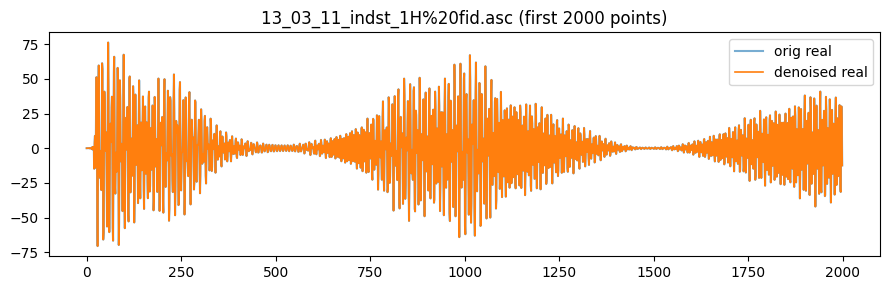


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=2.265e-08 | SNR orig=8.99 dB | den=8.99 dB | Δ=-0.00 dB


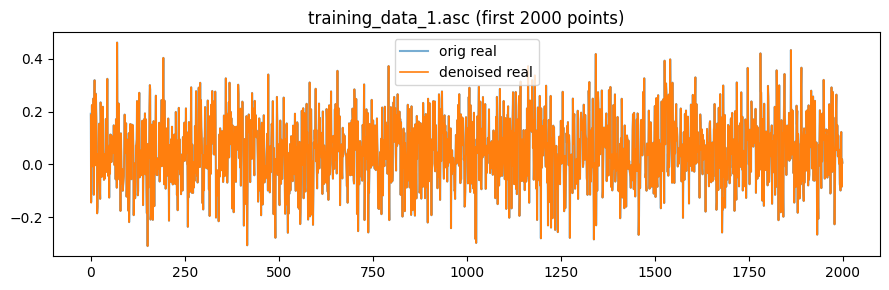


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=1.220e-08 | SNR orig=12.29 dB | den=12.29 dB | Δ=-0.00 dB


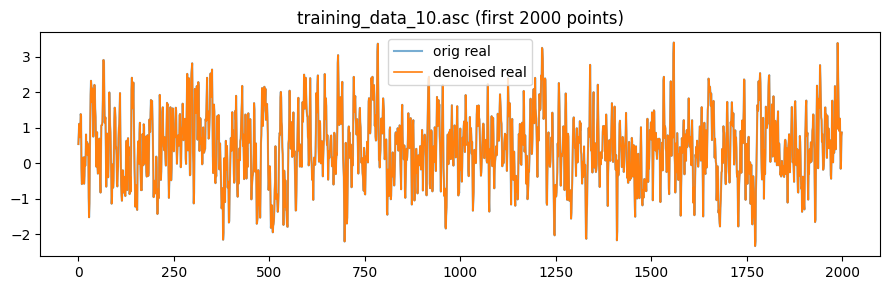


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=1.220e-08 | SNR orig=5.12 dB | den=5.12 dB | Δ=-0.00 dB


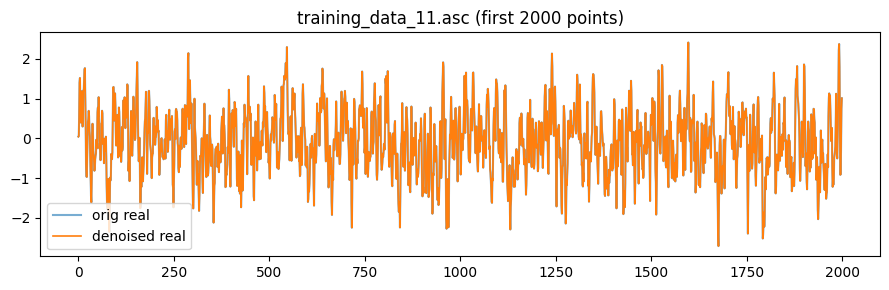


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=1.848e-08 | SNR orig=55.98 dB | den=55.98 dB | Δ=-0.00 dB


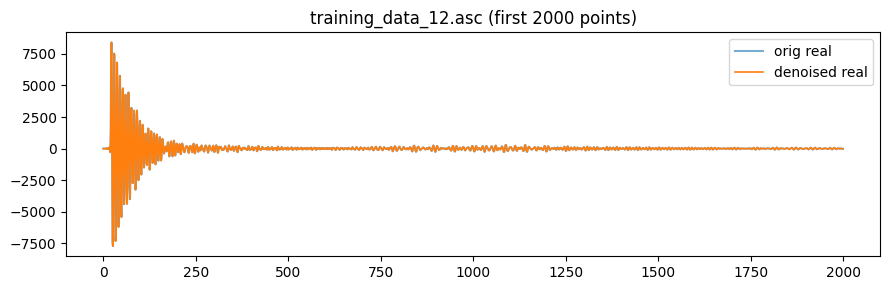


Head → training_data_13.asc
   time_s      real      imag
-1.506402 -0.000411 -0.003589
-1.505256 -0.000368 -0.003965
-1.504111 -0.000136 -0.003813
-1.502965 -0.000021 -0.003940
-1.501820 -0.000469 -0.003825
-1.500674 -0.000231 -0.003919
-1.499529 -0.000277 -0.003917
-1.498383  0.000010 -0.003933
Metrics → MSE=2.265e-08 | SNR orig=43.62 dB | den=43.62 dB | Δ=-0.00 dB


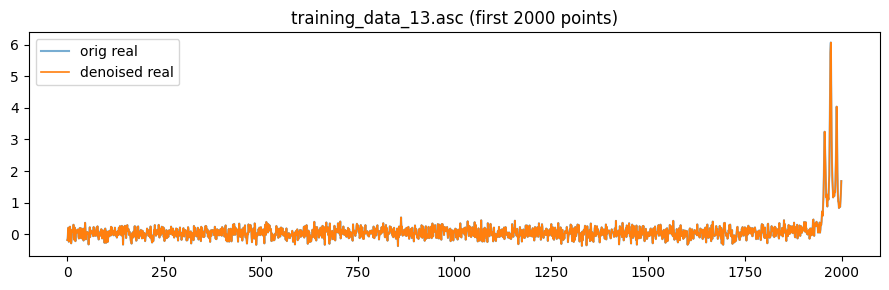


Head → training_data_14.asc
   time_s      real      imag
-1.506402 -0.000409 -0.001682
-1.505256 -0.000185 -0.002058
-1.504111 -0.000186 -0.001931
-1.502965 -0.000135 -0.002039
-1.501820  0.000043 -0.001769
-1.500674 -0.000262 -0.001837
-1.499529  0.000038 -0.001930
-1.498383 -0.000128 -0.001663
Metrics → MSE=2.265e-08 | SNR orig=43.57 dB | den=43.57 dB | Δ=-0.00 dB


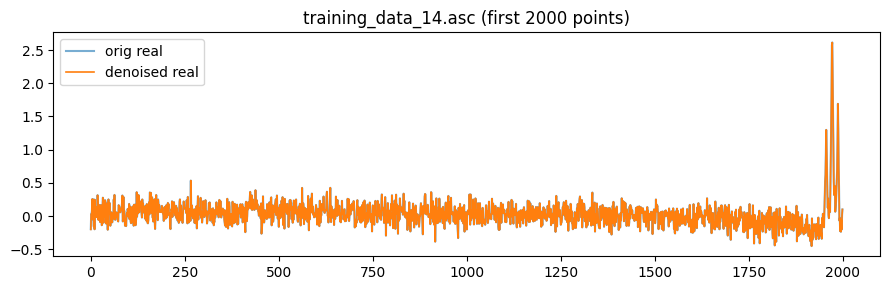


Head → training_data_15.asc
   time_s      real      imag
-1.506402 -0.003649 -0.041656
-1.505256  0.000163 -0.041425
-1.504111 -0.007017 -0.042556
-1.502965  0.004203 -0.046955
-1.501820 -0.006314 -0.041061
-1.500674  0.000418 -0.037207
-1.499529 -0.003996 -0.036962
-1.498383 -0.007572 -0.045544
Metrics → MSE=2.265e-08 | SNR orig=38.00 dB | den=38.00 dB | Δ=-0.00 dB


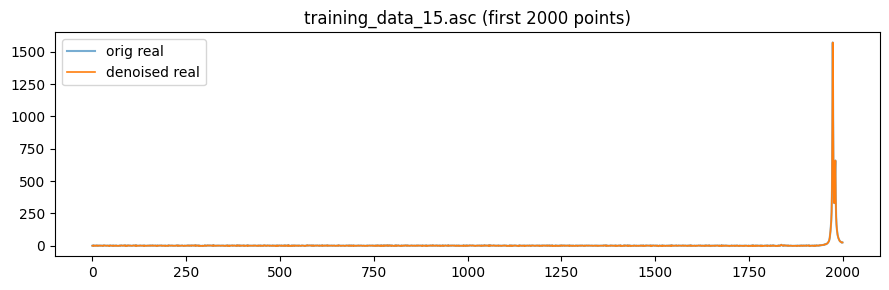


--- Summary ---
                       file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s      ΔSNR_dB
13_03_11_indst_1H%20fid.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414  3.84896  5.72205e-06
        training_data_1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442  -0.00108433
       training_data_10.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989 -7.62939e-06
       training_data_11.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989 -1.57356e-05
       training_data_12.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414 0.233389 -1.14441e-05
       training_data_13.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195  114.792  -

In [71]:

# ---- Helper functions ----
def _read_asc(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty or unreadable file: {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(np.float32)
        im = np.zeros_like(r, dtype=np.float32)
        t = np.arange(len(r), dtype=np.float32)
    else:
        t = arr[:, 0].astype(np.float32)
        r = arr[:, 1].astype(np.float32)
        im = (arr[:, 2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3):
    sig = real_imag_2xL.astype(np.float32, copy=True)
    L = sig.shape[1]
    if L < 8:
        return sig
    tail = slice(int(0.8 * L), L)
    baseline = sig[:, tail].mean(axis=1, keepdims=True)
    sig -= baseline
    tail_rms = np.sqrt((sig[:, tail] ** 2).mean(axis=1, keepdims=True) + 1e-12)
    tiny = tail_rms < 1e-6
    if np.any(tiny):
        half = slice(int(0.5 * L), L)
        alt_rms = np.sqrt((sig[:, half] ** 2).mean(axis=1, keepdims=True) + 1e-12)
        tail_rms = np.where(tiny, alt_rms, tail_rms)
    gain = np.minimum(1.0 / (tail_rms + 1e-12), max_gain)
    sig = (sig * gain).astype(np.float32)
    return sig

def _denoise(sig_2xL: np.ndarray):
    model_physics.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL.astype(np.float32)).unsqueeze(0).to(device)   # (1,2,L)
        y = model_physics(x).detach().cpu().squeeze(0).numpy()                     # (2,L)
    return y.astype(np.float32)

def _head_print(t, r, im, rows=8, label=None):
    df = pd.DataFrame({"time_s": t[:rows], "real": r[:rows], "imag": im[:rows]})
    if label: print(f"\n{label}")
    print(df.to_string(index=False))

def _snr_from_env(env):
    L = env.shape[0]
    if L < 16:
        return np.nan
    s0, s1 = 0, int(0.2 * L)
    n0, n1 = int(0.8 * L), L
    sig_rms = np.sqrt(np.mean(env[s0:s1] ** 2) + 1e-12)
    noise_rms = np.sqrt(np.mean(env[n0:n1] ** 2) + 1e-12)
    return 20.0 * np.log10(sig_rms / noise_rms)

def _robust_dt(t):
    if t.size < 2: return np.nan
    d = np.diff(t)
    d = d[np.isfinite(d) & (d > 0)]
    return float(np.median(d)) if d.size else np.nan

@torch.no_grad()
def _estimate_t2_from_pair(pair_2xL, dt, frac=0.25):
    if pair_2xL.shape[1] < 32 or not np.isfinite(dt) or dt <= 0:
        return np.nan
    z = torch.from_numpy(pair_2xL.astype(np.float32))
    r, i = z[0], z[1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    tvec = torch.arange(n, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(tvec), tvec], dim=1)
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    b = float(sol[1])
    return float((-1.0 / b) if b < 0 else (0.2 * n * dt))

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

### this is important so that our dwell times aren't hard coded

In [72]:
use_cuda = torch.cuda.is_available()
scaler = GradScaler('cuda', enabled=use_cuda)
print(f"[AMP] device={'cuda' if use_cuda else 'cpu'} | GradScaler enabled={scaler.is_enabled()}")

[AMP] device=cpu | GradScaler enabled=False


In [73]:
# --- Loss Functions (Unified Cell) ---

import torch

# --- Physics-informed combined loss ---
def synth_batch_phys(batch_size, L, snr_std=0.03, colored_noise=True, device='cpu'):
    """
    Returns (x_noisy, y_clean):
      y_clean: synthetic clean complex FID (2, L)
      x_noisy: y_clean + noise
    """
    # build clean signal
    t = torch.arange(L, device=device).float()
    freqs = torch.randn(batch_size, 5, device=device) * 0.15
    phases = torch.randn(batch_size, 5, device=device) * math.pi
    decays = torch.rand(batch_size, 5, device=device) * 0.5 + 0.2
    clean_real = torch.zeros(batch_size, L, device=device)
    clean_imag = torch.zeros(batch_size, L, device=device)
    for k in range(5):
        w = 2 * math.pi * freqs[:, k].unsqueeze(1)
        phi = phases[:, k].unsqueeze(1)
        decay = torch.exp(-decays[:, k].unsqueeze(1) * (t / L))
        comp = decay * torch.cos(w * t + phi)
        comp_i = decay * torch.sin(w * t + phi)
        clean_real += comp
        clean_imag += comp_i
    y_clean = torch.stack([clean_real, clean_imag], dim=1)  # (B,2,L)

    # noise
    base_noise = torch.randn_like(y_clean)
    if colored_noise:
        filt = torch.linspace(1.0, 0.3, L, device=device)
        base_noise = base_noise * filt.unsqueeze(0).unsqueeze(0)

    # scale noise relative to tail RMS of clean
    tail = y_clean[..., int(0.8 * L):]
    tail_rms = torch.sqrt((tail ** 2).mean(dim=-1, keepdim=True) + 1e-12)

    noise_scale = snr_std * tail_rms  # snr_std governs relative magnitude
    noise = base_noise * noise_scale * 10
    x_noisy = y_clean + noise
    # sanity guard
    print("Noise mean", noise.abs().mean().item(), "Tail RMS", tail_rms.mean().item())
    assert (x_noisy - y_clean).abs().mean() > 1e-6, "Noise injection too small."

    return x_noisy, y_clean

# RESTORED dt usage ---------------------------------------------------
def combined_loss(pred, target, dt: float, x_ref=None):
    """Loss using dwell time to weight spectral differences (frequency emphasis)."""
    mse = torch.mean((pred - target) ** 2)
    fft_p = torch.fft.rfft(pred, dim=-1)
    fft_t = torch.fft.rfft(target, dim=-1)
    # Magnitudes
    mag_p = torch.sqrt(fft_p.real**2 + fft_p.imag**2)
    mag_t = torch.sqrt(fft_t.real**2 + fft_t.imag**2)
    # Frequency axis from dt
    freqs = torch.fft.rfftfreq(pred.shape[-1], d=dt).to(pred.device)  # Hz
    freqs_norm = freqs / (freqs[-1] + 1e-12)
    # Weight higher frequencies slightly (prevent over-smoothing there)
    w_freq = (1.0 + 0.5 * freqs_norm).unsqueeze(0).unsqueeze(0)
    spec_mse = torch.mean(w_freq * (mag_p - mag_t) ** 2)
    if x_ref is not None:
        resid_pen = torch.mean((pred - x_ref) ** 2)
    else:
        resid_pen = torch.zeros((), device=pred.device)
    w_time, w_spec, w_resid = 1.0, 0.25, 0.1
    return w_time*mse + w_spec*spec_mse + w_resid*resid_pen

In [74]:
# ---- Consolidated Physics Model Training & Fine-Tuning ----
# ...existing code above unchanged...
for ep in range(EPOCHS):
    model_physics.train()
    running_loss = 0.0
    sn = NOISE_SCHEDULE[min(ep, len(NOISE_SCHEDULE)-1)]
    for _ in range(STEPS_PER_EPOCH):
        x, y = synth_batch_phys(batch_size=BATCH_SIZE, L=CROP_LEN, snr_std=sn, colored_noise=True, device=device)
        opt.zero_grad(set_to_none=True)
        pred = model_physics(x)
        loss = combined_loss(pred, y, dt=dt_synth, x_ref=x)
        if not torch.isfinite(loss) or loss.grad_fn is None:
            print('[WARN] skip step: non-finite or no-grad loss')
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
        opt.step()
        running_loss += float(loss.detach())
    # Validation
    model_physics.eval()
    with torch.no_grad():
        xv, yv = synth_batch_phys(batch_size=64, L=CROP_LEN, snr_std=NOISE_SCHEDULE[-1], colored_noise=True, device=device)
        pv = model_physics(xv)
        mse_noisy, mse_pred, snr_impr_db = calc_snr_improvement(xv, pv, yv)
    print(f'Epoch {ep+1}: train_loss={running_loss/STEPS_PER_EPOCH:.6e} | val base={mse_noisy:.6e} model={mse_pred:.6e} ΔSNR={snr_impr_db:.2f} dB')
# ...existing code continuing...

Noise mean 0.22990605235099792 Tail RMS 1.098358154296875
Noise mean 0.22830981016159058 Tail RMS 1.1048364639282227
Noise mean 0.22286538779735565 Tail RMS 1.0754263401031494
Noise mean 0.22543266415596008 Tail RMS 1.0866937637329102
Noise mean 0.22987784445285797 Tail RMS 1.1061124801635742
Noise mean 0.22601082921028137 Tail RMS 1.0883680582046509
Noise mean 0.22134818136692047 Tail RMS 1.0709737539291382
Noise mean 0.22050318121910095 Tail RMS 1.0698912143707275
Noise mean 0.22657345235347748 Tail RMS 1.093766689300537
Noise mean 0.21839389204978943 Tail RMS 1.0504353046417236
Noise mean 0.22242413461208344 Tail RMS 1.0711615085601807
Noise mean 0.2258702516555786 Tail RMS 1.0903080701828003
Noise mean 0.22548836469650269 Tail RMS 1.0844007730484009
Noise mean 0.21981555223464966 Tail RMS 1.0566825866699219
Noise mean 0.23146459460258484 Tail RMS 1.108269453048706
Noise mean 0.22504229843616486 Tail RMS 1.0872802734375
Noise mean 0.2127656787633896 Tail RMS 1.0194810628890991
Noise

In [75]:
# Before fine-tuning, add validation check:
print(f"[Check] Example real FID stats before fine-tune:")
sample_file = files[0]  # Use 'files' directly (defined in Cell 8)
t_s, r_s, i_s = _read_asc(sample_file)
pair_s = np.stack([r_s, i_s])
x_s = _preprocess_pair(pair_s)
print(f"  Real signal range: [{x_s.min():.3e}, {x_s.max():.3e}]")
print(f"  Real signal std: {x_s.std():.3e}")

# Compare with synthetic batch
x_syn, y_syn = synth_batch_phys(batch_size=4, L=CROP_LEN, snr_std=0.025, device=device)
print(f"  Synth signal range: [{x_syn.min():.3e}, {x_syn.max():.3e}]")
print(f"  Synth signal std: {x_syn.std():.3e}")

# Compute global scale factor for real data
real_scale = x_s.std() / x_syn.std().item()
print(f"  Scale ratio (real/synth): {real_scale:.2f}×")

if REAL_FINETUNE_EPOCHS > 0:
    files_ft = files
    old_lr = opt.param_groups[0]['lr']
    # Lower LR more aggressively for fine-tuning
    for g in opt.param_groups: 
        g['lr'] = old_lr * 0.01  # Changed from 0.1 to 0.01
    
        # ...existing code...
    
    for ep in range(REAL_FINETUNE_EPOCHS):
        model_physics.train()
        total_loss, count = 0.0, 0
        for f in files_ft:
            t_r, r_r, i_r = _read_asc(f)
            pair = np.stack([r_r, i_r])
            x_real_np = _preprocess_pair(pair, max_gain=1e3)
            x_real_np = x_real_np / real_scale
            
            dt_i = _robust_dt(t_r)
            if not np.isfinite(dt_i) or dt_i <= 0:
                dt_i = dt_synth
                
            x_real = torch.from_numpy(x_real_np).float().unsqueeze(0).to(device)
            
            # ✅ NEW: Create pseudo-clean target by denoising with current model
            model_physics.eval()
            with torch.no_grad():
                y_pseudo_clean = model_physics(x_real).detach()
            model_physics.train()
            
            opt.zero_grad(set_to_none=True)
            pred = model_physics(x_real)
            # ✅ Train to reproduce model's own denoised output (consistency regularization)
            loss = combined_loss(pred, y_pseudo_clean, dt=dt_i, x_ref=x_real)
            
            if not torch.isfinite(loss) or loss.grad_fn is None:
                print(f'[Skip unstable] {os.path.basename(f)}')
                continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
            opt.step()
            total_loss += float(loss.detach())
            count += 1
        print(f'Real fine-tune epoch {ep+1}/{REAL_FINETUNE_EPOCHS}: loss={total_loss/max(1,count):.6e} over {count} files')
    # Restore original learning rate
    for g in opt.param_groups: 
        g['lr'] = old_lr

[Check] Example real FID stats before fine-tune:
  Real signal range: [-8.430e+01, 8.984e+01]
  Real signal std: 8.704e+00
Noise mean 0.13547345995903015 Tail RMS 1.0486973524093628
  Synth signal range: [-4.826e+00, 4.482e+00]
  Synth signal std: 1.290e+00
  Scale ratio (real/synth): 6.75×
Real fine-tune epoch 1/10: loss=2.661117e-01 over 27 files
Real fine-tune epoch 2/10: loss=2.405075e-01 over 27 files
Real fine-tune epoch 3/10: loss=2.213740e-01 over 27 files
Real fine-tune epoch 4/10: loss=2.060387e-01 over 27 files
Real fine-tune epoch 5/10: loss=1.933921e-01 over 27 files
Real fine-tune epoch 6/10: loss=1.823685e-01 over 27 files
Real fine-tune epoch 7/10: loss=1.724962e-01 over 27 files
Real fine-tune epoch 8/10: loss=1.636097e-01 over 27 files
Real fine-tune epoch 9/10: loss=1.555078e-01 over 27 files
Real fine-tune epoch 10/10: loss=1.481004e-01 over 27 files


[Run] Starting denoise + metrics...

Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=7.675e-02 | SNR orig=24.26 dB | den=24.08 dB | Δ=-0.18 dB


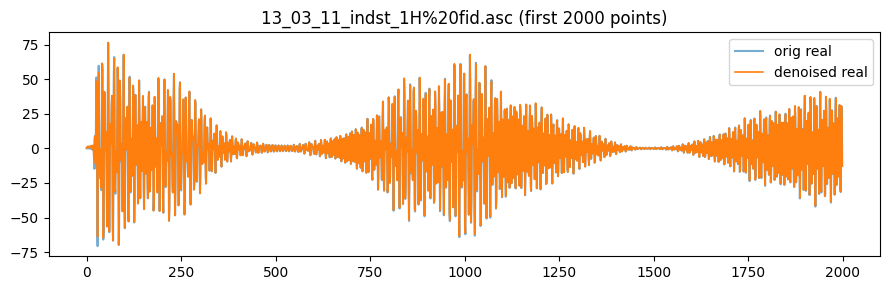


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=1.727e+00 | SNR orig=8.99 dB | den=11.51 dB | Δ=2.52 dB


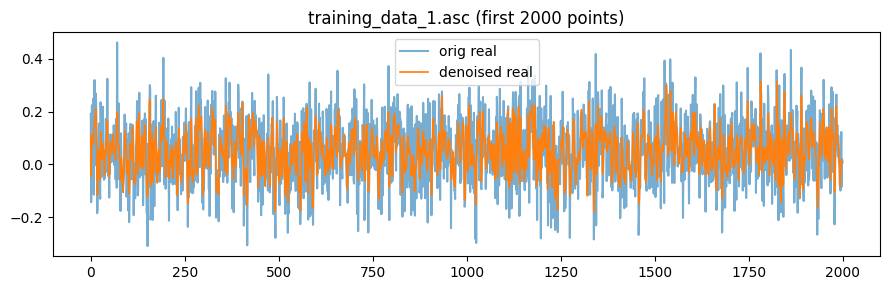


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=5.372e-01 | SNR orig=12.29 dB | den=12.00 dB | Δ=-0.29 dB


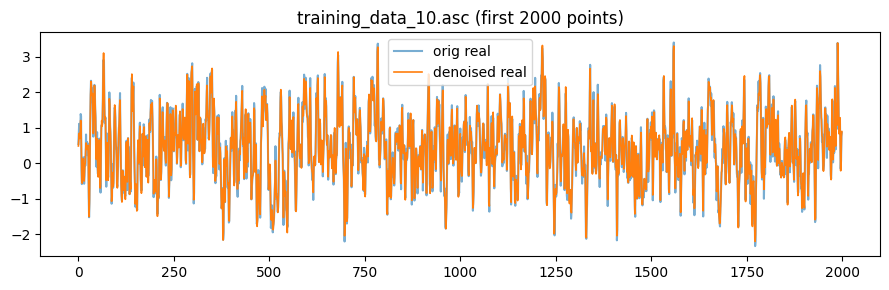


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=1.542e-01 | SNR orig=5.12 dB | den=5.11 dB | Δ=-0.01 dB


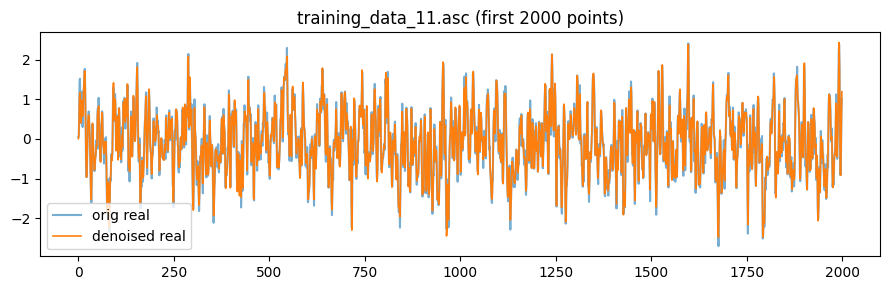


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=4.441e+02 | SNR orig=55.98 dB | den=56.01 dB | Δ=0.03 dB


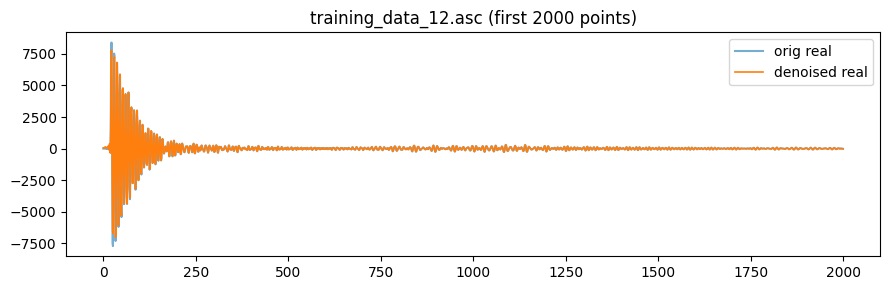


Head → training_data_13.asc
   time_s      real      imag
-1.506402 -0.000411 -0.003589
-1.505256 -0.000368 -0.003965
-1.504111 -0.000136 -0.003813
-1.502965 -0.000021 -0.003940
-1.501820 -0.000469 -0.003825
-1.500674 -0.000231 -0.003919
-1.499529 -0.000277 -0.003917
-1.498383  0.000010 -0.003933
Metrics → MSE=7.387e-01 | SNR orig=43.62 dB | den=43.97 dB | Δ=0.35 dB


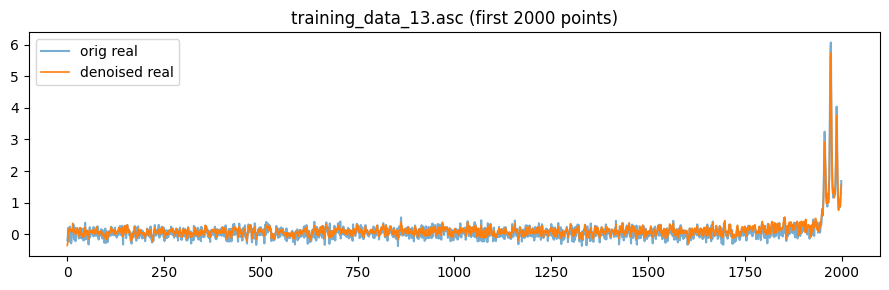


Head → training_data_14.asc
   time_s      real      imag
-1.506402 -0.000409 -0.001682
-1.505256 -0.000185 -0.002058
-1.504111 -0.000186 -0.001931
-1.502965 -0.000135 -0.002039
-1.501820  0.000043 -0.001769
-1.500674 -0.000262 -0.001837
-1.499529  0.000038 -0.001930
-1.498383 -0.000128 -0.001663
Metrics → MSE=7.152e-01 | SNR orig=43.57 dB | den=44.78 dB | Δ=1.21 dB


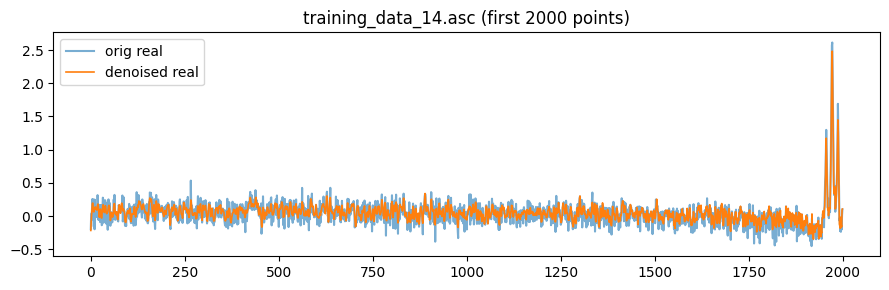


Head → training_data_15.asc
   time_s      real      imag
-1.506402 -0.003649 -0.041656
-1.505256  0.000163 -0.041425
-1.504111 -0.007017 -0.042556
-1.502965  0.004203 -0.046955
-1.501820 -0.006314 -0.041061
-1.500674  0.000418 -0.037207
-1.499529 -0.003996 -0.036962
-1.498383 -0.007572 -0.045544
Metrics → MSE=3.868e+01 | SNR orig=38.00 dB | den=38.44 dB | Δ=0.44 dB


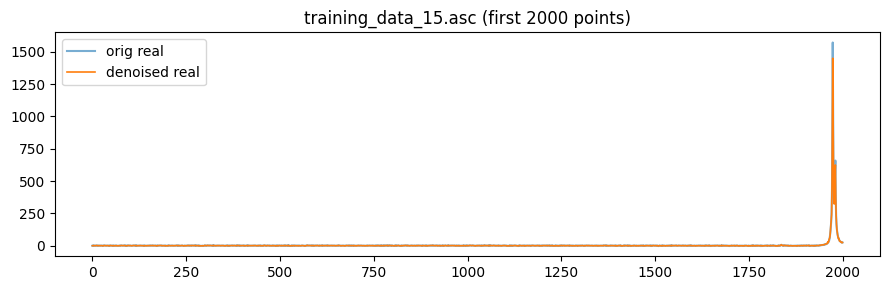


--- Summary ---
                       file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s     ΔSNR_dB
13_03_11_indst_1H%20fid.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414  3.84896   -0.180056
        training_data_1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442     2.52387
       training_data_10.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989   -0.285233
       training_data_11.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989  -0.0120983
       training_data_12.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414 0.233389   0.0343323
       training_data_13.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195  114.792    0.347

In [76]:
# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")